# Solver and SLM Accuracy and Runtime Notebook

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
# from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
# import json


import sys
sys.path.append("./src")
from TOV_class import TOVsolver
from SLM import SLM
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()

In [3]:
error_threshold = 1e-6

In [4]:
# # real quick let's get the SLM main code "wrapped" into a function I can call from here

# SLM_modes = 8

# def SLM(X, svdSize=SLM_modes):
#     radius, pres, mass, tidal_def = X
    
#     # get data defined and "formatted"
#     linT = np.arange(len(pres))
#     X = [np.log(radius), np.log(pres), np.log(mass), np.log(tidal_def)]
#     X = np.asarray(X, dtype=np.float64)
    
#     startDMDTime = time.time()
#     phi, omega, lam, b, Xdmd, S = DMD(X, svdSize, (linT[-1] - linT[0]) / len(linT))
#     endDMDTime = time.time()
#     runtime = endDMDTime - startDMDTime
    
#     rad_DMD = np.exp(Xdmd[0].real)
#     pres_DMD = np.exp(Xdmd[1].real)
#     mass_DMD = np.exp(Xdmd[2].real)
#     tidal_DMD = np.exp(Xdmd[3].real)
    
    
#     return rad_DMD, pres_DMD, mass_DMD, tidal_DMD, runtime

In [5]:
eos_path = "./EOS_Data/"

# check the accuracy and runtimes with the tabular EOSs (5 of them)
files_to_check = ["BL_eos.table", 
                  "FSUGarnetNStarEOSA.txt", 
                  "sorted_Sly4.dat", 
                  "DS_CMF_eos.table", 
                  "apr_eos.table"]
eos_names = ["BL", "FSU Garnet", "SLy4", "DSCMF", "APR"]

In [6]:
sol_pts = 2500  # number of points used per iteration for non solve_ivp solvers
number_of_solves = 1  # make this more for checking the runtimes !

# these empty lists will get filled with their corresponding runtimes per solve (size = `number_of_solves * 5`)
HF_runtimes = {"exact": [],
               "RK4": [],
               "RK2": [],
               "euler": []}
SLM_runtimes = {"exact": [],
                "RK4": [],
                "RK2": [],
                "euler": []}

## Calculate Exact (Adaptive) Solver

This uses `solve_ivp`

In [7]:
# store the solutions per EOS
exact_HF_results = {}
exact_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        # some solve_ivp methods: "RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"
        # "Radau" is particularly good for stick ODEs (like these). But RK45 should also be good too.
        tov_exact = TOVsolver(f"{eos_path}{file}", tidal=True, solver="solve_ivp", solve_ivp_kwargs={"method": "RK45", 
                                                                                                        "atol": 1e-8, 
                                                                                                        "rtol": 1e-8})
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_exact.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["exact"].append(HF_runtime)
        
        # store data
        rad = tov_exact.total_radius
        pres = tov_exact.total_pres_central
        mass = tov_exact.total_mass
        tidal = tov_exact.k2
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["exact"].append(SLM_runtime)
        
        exact_HF_results[eos_name] = X
        exact_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")
#




Checking BL: Woo it worked!
Max mass:  2.082759 Radius:  10.198613 Central pressure:  867.67565
Testing r=1: Max absolute error = 879.103774
Testing r=2: Max absolute error = 1093.952608
Testing r=3: Max absolute error = 3288.571001
Testing r=4: Max absolute error = 758.417993
Testing r=5: Max absolute error = 363.062866
Testing r=6: Max absolute error = 58.301738
Testing r=7: Max absolute error = 19.695289
Testing r=8: Max absolute error = 1.307213
Testing r=9: Max absolute error = 33.502734
Testing r=10: Max absolute error = 40667.808058
Testing r=11: Max absolute error = 7387.909417
Testing r=12: Max absolute error = 1819.541290
Testing r=13: Max absolute error = 18803.091857
Testing r=14: Max absolute error = 6032.544415
Optimal 'r' determined: 8 (Max absolute error = 1.307213)
HF solved in 2.997 seconds.
SLM solved in 0.00201 seconds.
speedup: 1491.1672399478116


Checking FSU Garnet: Woo it worked!
Max mass:  2.066601 Radius:  11.640964 Central pressure:  342.097307
Testing r=1

/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


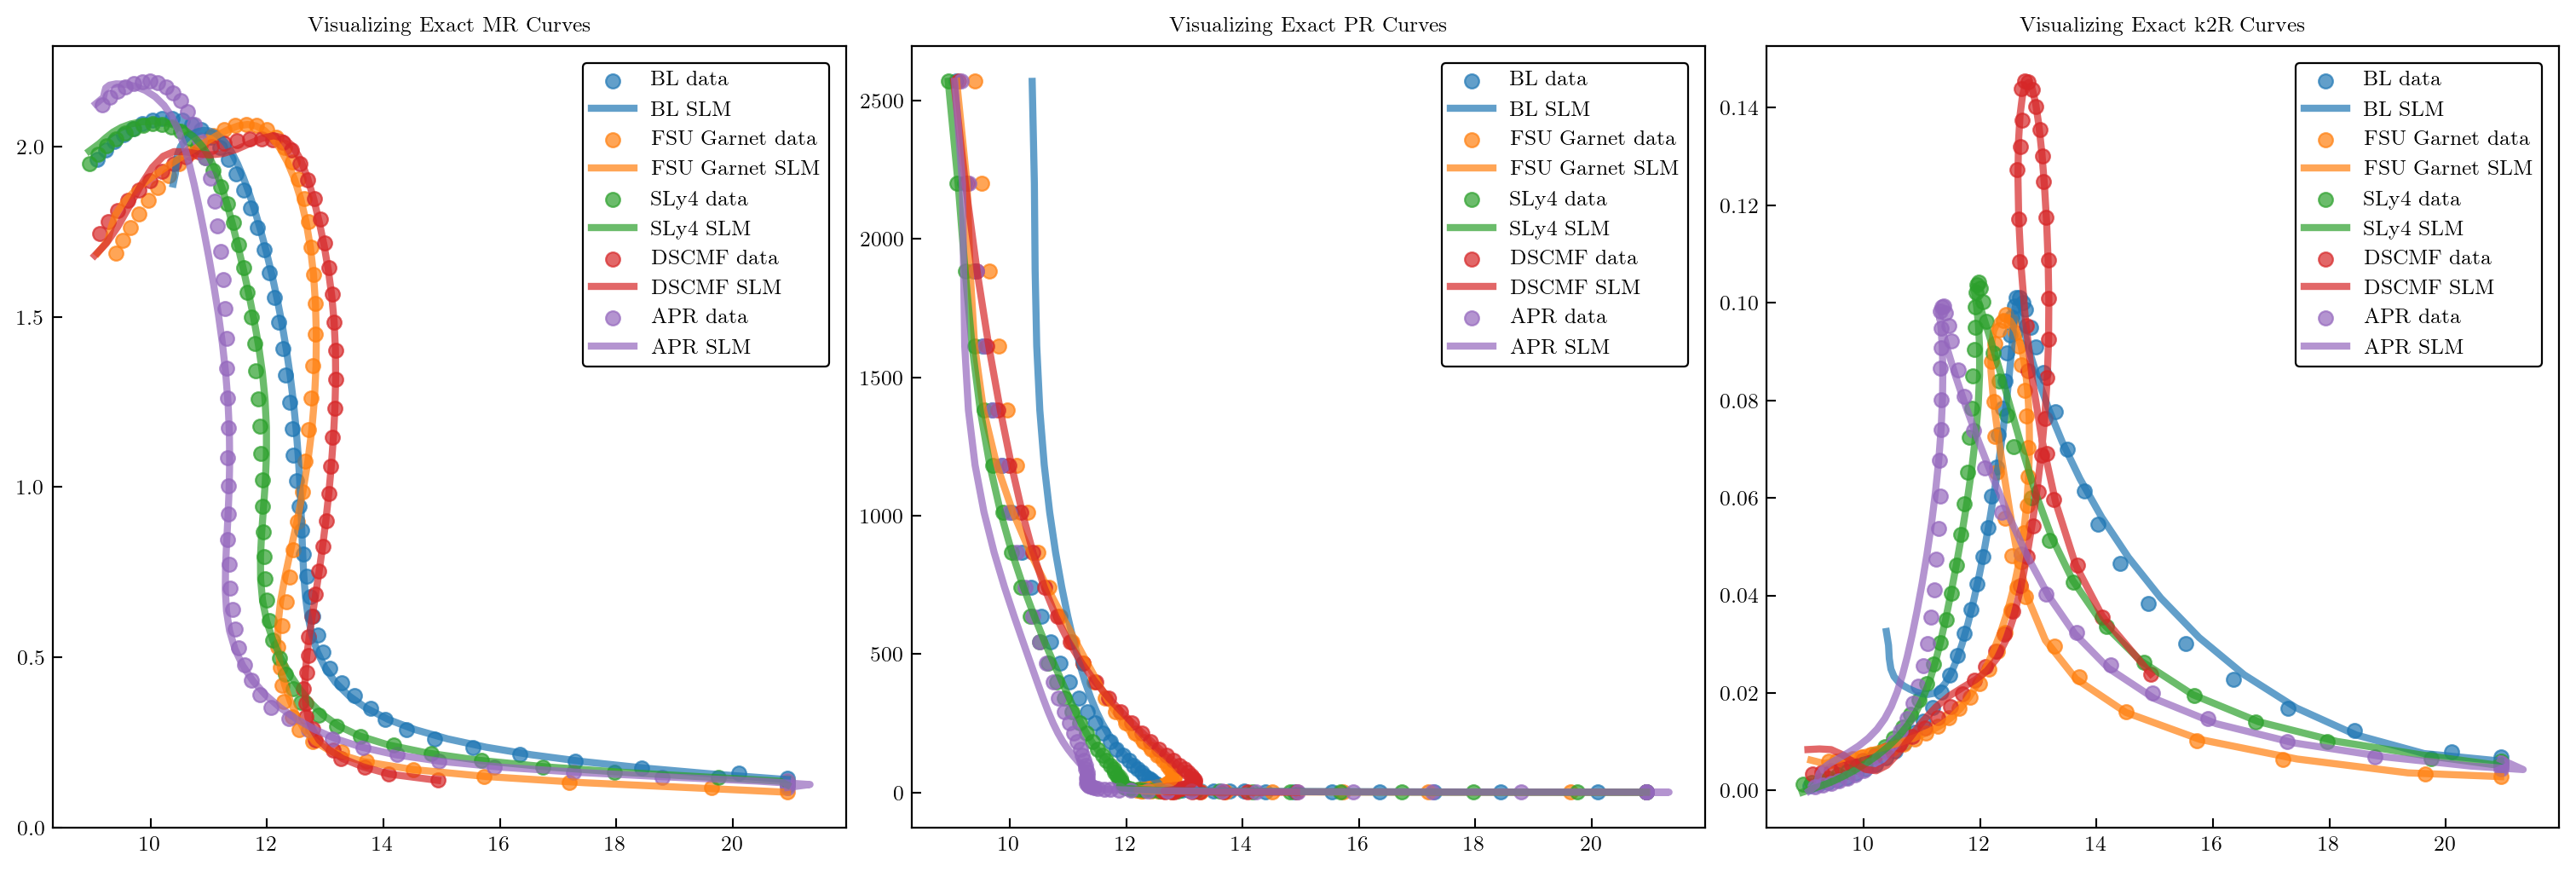

In [8]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Exact MR Curves")
for eos in eos_names:
    ax[0].scatter(exact_HF_results[eos][0], exact_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Exact PR Curves")
for eos in eos_names:
    ax[1].scatter(exact_HF_results[eos][0], exact_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing Exact k2R Curves")
for eos in eos_names:
    ax[2].scatter(exact_HF_results[eos][0], exact_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK4 solver

In [9]:
# store the solutions per EOS
RK4_HF_results = {}
RK4_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK4 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK4", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK4.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK4"].append(HF_runtime)
        
        # store data
        rad = tov_RK4.total_radius
        pres = tov_RK4.total_pres_central
        mass = tov_RK4.total_mass
        tidal = tov_RK4.k2
        
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["RK4"].append(SLM_runtime)
        
        RK4_HF_results[eos_name] = X
        RK4_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")
#




Checking BL: Woo it worked!
Max mass:  2.082758 Radius:  10.193479 Central pressure:  867.67565
Testing r=1: Max absolute error = 900.604700
Testing r=2: Max absolute error = 1446.771983
Testing r=3: Max absolute error = 3199.640602
Testing r=4: Max absolute error = 806.147131
Testing r=5: Max absolute error = 672.312096
Testing r=6: Max absolute error = 127.458673
Testing r=7: Max absolute error = 17.133714
Testing r=8: Max absolute error = 22.233030
Testing r=9: Max absolute error = 439.061816
Testing r=10: Max absolute error = 0.160923
Testing r=11: Max absolute error = 22.945290
Testing r=12: Max absolute error = 10753.126641
Testing r=13: Max absolute error = 422.397960
Testing r=14: Max absolute error = 3.676782
Optimal 'r' determined: 10 (Max absolute error = 0.160923)
HF solved in 11.03 seconds.
SLM solved in 0.002241 seconds.
speedup: 4920.004149377593


Checking FSU Garnet: Woo it worked!
Max mass:  2.066602 Radius:  11.640836 Central pressure:  342.097307
Testing r=1: Max 

/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


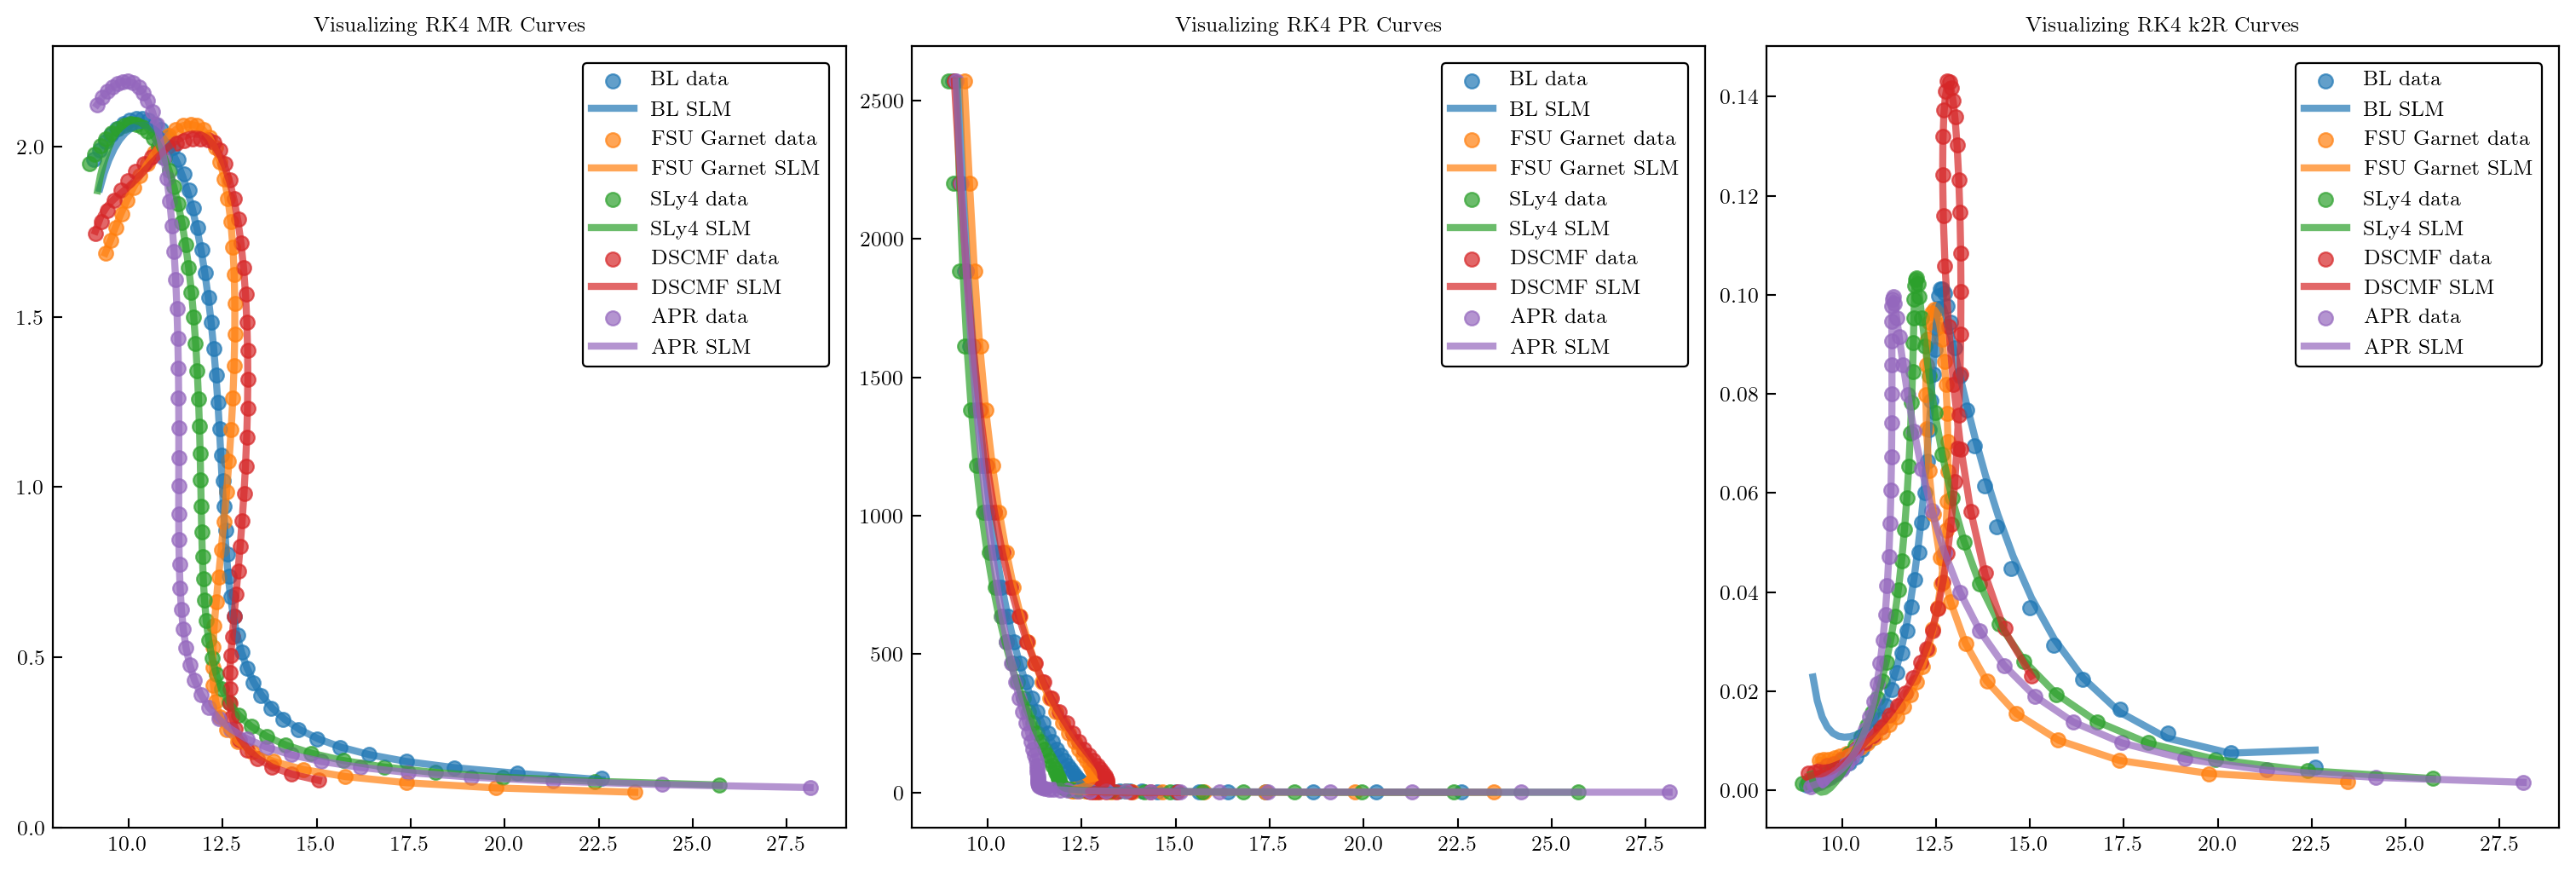

In [10]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK4 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK4 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing RK4 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK2 Solver

In [11]:
# store the solutions per EOS
RK2_HF_results = {}
RK2_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK2 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK2", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK2.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK2"].append(HF_runtime)
        
        # store data
        rad = tov_RK2.total_radius
        pres = tov_RK2.total_pres_central
        mass = tov_RK2.total_mass
        tidal = tov_RK2.k2
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        SLM_runtimes["RK2"].append(SLM_runtime)
        
        RK2_HF_results[eos_name] = X
        RK2_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")
#




Checking BL: Woo it worked!
Max mass:  2.082767 Radius:  10.220282 Central pressure:  867.67565
Testing r=1: Max absolute error = 901.786465
Testing r=2: Max absolute error = 1443.383371
Testing r=3: Max absolute error = 3250.295949
Testing r=4: Max absolute error = 782.852700
Testing r=5: Max absolute error = 660.992346
Testing r=6: Max absolute error = 116.716842
Testing r=7: Max absolute error = 21.762988
Testing r=8: Max absolute error = 5.753250
Testing r=9: Max absolute error = 70.061618
Testing r=10: Max absolute error = 202.067940
Testing r=11: Max absolute error = 5309.271408
Testing r=12: Max absolute error = 30394.577157
Testing r=13: Max absolute error = 682.669159
Testing r=14: Max absolute error = 3.961904
Optimal 'r' determined: 14 (Max absolute error = 3.961904)
HF solved in 5.328 seconds.
SLM solved in 0.001892 seconds.
speedup: 2815.840347782258


Checking FSU Garnet: Woo it worked!
Max mass:  2.066609 Radius:  11.667638 Central pressure:  342.097307
Testing r=1: Ma

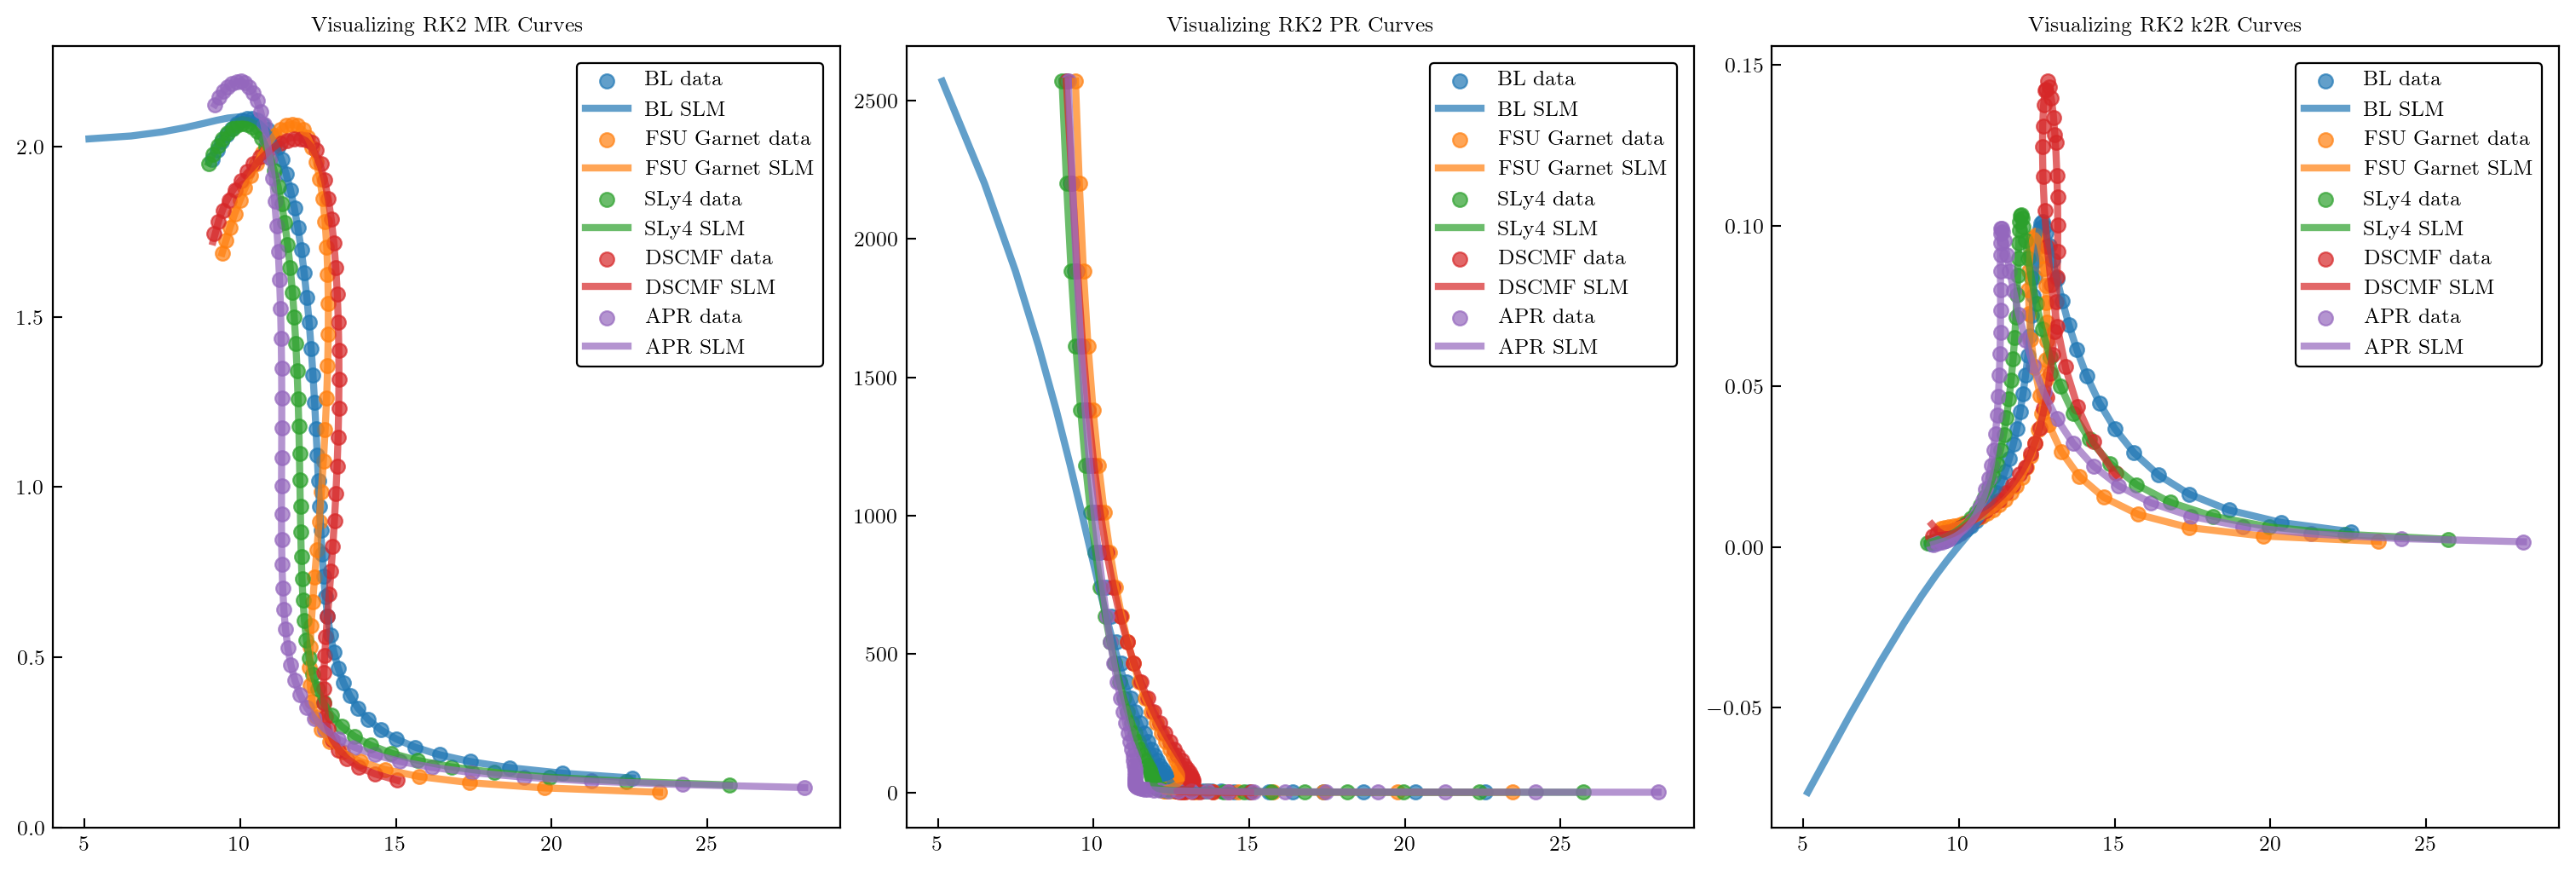

In [12]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing RK2 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK2 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing RK2 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

# Check Euler Solver

In [13]:
# store the solutions per EOS
euler_HF_results = {}
euler_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_euler = TOVsolver(f"{eos_path}{file}", tidal=True, solver="euler", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_euler.tov_routine(verbose=False, write_to_file=False, pres_init=2.0)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["euler"].append(HF_runtime)
        
        # store data
        rad = tov_euler.total_radius
        pres = tov_euler.total_pres_central
        mass = tov_euler.total_mass
        tidal = tov_euler.k2
        
        X = np.array([rad, pres, mass, tidal], dtype=np.float64)
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        X_SLM = SLM(X, dt, error_threshold=error_threshold)[4]
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["euler"].append(SLM_runtime)
        
        euler_HF_results[eos_name] = X
        euler_SLM_results[eos_name] = X_SLM
        
        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime}")
#




Checking BL: Woo it worked!
Max mass:  2.081757 Radius:  10.233683 Central pressure:  743.001089
Testing r=1: Max absolute error = 891.592077
Testing r=2: Max absolute error = 1294.173711
Testing r=3: Max absolute error = 3527.956274
Testing r=4: Max absolute error = 763.293734
Testing r=5: Max absolute error = 641.577851
Testing r=6: Max absolute error = 26.972109
Testing r=7: Max absolute error = 5338.826024
Testing r=8: Max absolute error = 4513.321503
Testing r=9: Max absolute error = 245.987687
Testing r=10: Max absolute error = 73.130610
Testing r=11: Max absolute error = 296.412048
Testing r=12: Max absolute error = 304.914790
Testing r=13: Max absolute error = 113.037753
Testing r=14: Max absolute error = 0.621790
Optimal 'r' determined: 14 (Max absolute error = 0.621790)
HF solved in 2.685 seconds.
SLM solved in 0.002033 seconds.
speedup: 1320.6081857628708


Checking FSU Garnet: Woo it worked!
Max mass:  2.066157 Radius:  11.533624 Central pressure:  342.097307
Testing r=1:

/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


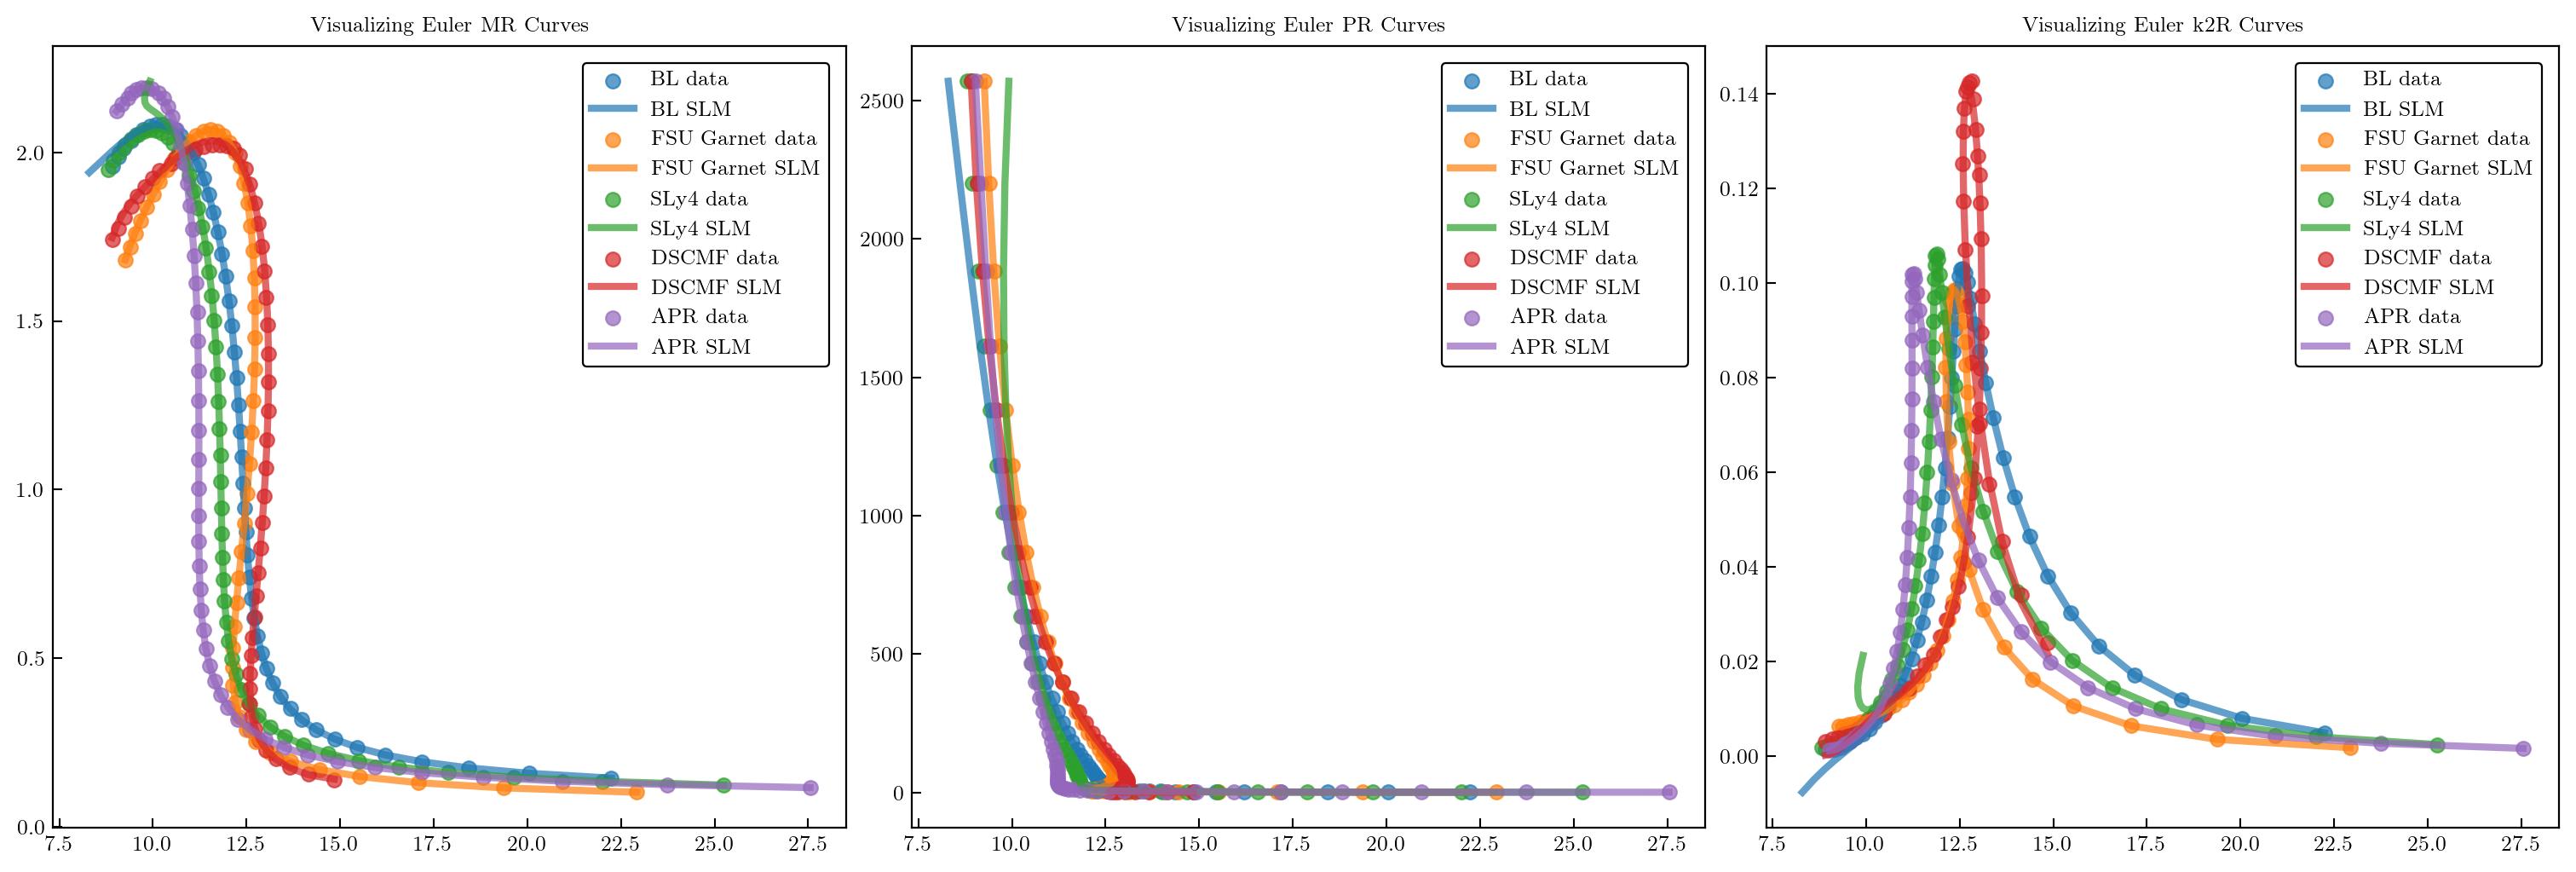

In [14]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

ax[0].set_title("Visualizing Euler MR Curves")
for eos in eos_names:
    ax[0].scatter(euler_HF_results[eos][0], euler_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Euler PR Curves")
for eos in eos_names:
    ax[1].scatter(euler_HF_results[eos][0], euler_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].legend()

ax[2].set_title("Visualizing Euler k2R Curves")
for eos in eos_names:
    ax[2].scatter(euler_HF_results[eos][0], euler_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Nice! Now look at errors

I'm not totally sure the best way to go about this. So I'll look at where the peak is on the MR curve since that's how we did the errors on the table originally.

In [15]:
def the_good_interpolator(x_tov, y_tov, x_dmd):
    # Create a normalized parameter t that corresponds to the original x values
    t_original = np.linspace(0, 1, num=len(x_tov))
    
    # Create cubic splines for original x and y
    cs_x = CubicSpline(t_original, x_tov, bc_type='natural')
    cs_y = CubicSpline(t_original, y_tov, bc_type='natural')
    
    # Create a new parameter t for the new x-values
    t_new = np.linspace(0, 1, num=len(x_dmd))
    
    # Interpolate to find the corresponding y-values for the new x-values
    y_new = cs_y(t_new)
    
    return x_dmd, y_new

def percent_error(HF, SLM):
    try:
        error = 100 * np.abs(HF - SLM) / HF
    except:
        error = np.nan
    return error

In [16]:
errors = {}  # for storing all errors
exact_HF = []  # for comparing HF solvers to the exact results

solvers = ["exact", "RK4", "RK2", "euler"]
for solver in solvers:
    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        HF = eval(f"{solver}_HF_results[\"{eos_name}\"]")
        SLM = eval(f"{solver}_SLM_results[\"{eos_name}\"]")
        
        # select max point on MR curve
        # for HF
        HF_max_index = np.where(HF[2] == np.max(HF[2]))[0][0]  # grab index the maximum mass
        HF_max_rad = HF[0][HF_max_index]
        HF_max_mass = HF[2][HF_max_index]
        # for SLM
        SLM_max_index = np.where(SLM[2] == np.max(SLM[2]))[0][0]  # grab index the maximum mass
        SLM_max_rad = SLM[0][SLM_max_index]
        SLM_max_mass = SLM[2][SLM_max_index]
        
        # store the exact results for comparing to the other solvers
        if (solver == "exact"):
            exact_HF.append([HF_max_rad, HF_max_mass])
        else:
            errors[f"{eos_name} {solver} HF rad"] = percent_error(exact_HF[i][0], HF_max_rad)
            errors[f"{eos_name} {solver} HF mass"] = percent_error(exact_HF[i][1], HF_max_mass)
        
        # compare SLM to it's corresponding HF solver
        errors[f"{eos_name} {solver} SLM rad"] = percent_error(HF_max_rad, SLM_max_rad)
        errors[f"{eos_name} {solver} SLM mass"] = percent_error(HF_max_mass, SLM_max_mass)


# print results
for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    print(f"{eos_name} EOS:")
    for solver in solvers:
        if (solver != "exact"):
            print(f"{solver} HF  error:")
            print(f"   rad={errors[f"{eos_name} {solver} HF rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} HF mass"]:.6}")
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
        else:
            print(f"{solver} SLM error:")
            print(f"   rad={errors[f"{eos_name} {solver} SLM rad"]:.6}")
            print(f"   mass={errors[f"{eos_name} {solver} SLM mass"]:.6}")
    print("")


BL EOS:
exact SLM error:
   rad=6.80703
   mass=1.67226
RK4 HF  error:
   rad=0.0503373
   mass=6.68655e-05
RK4 SLM error:
   rad=1.79316
   mass=0.895522
RK2 HF  error:
   rad=0.212472
   mass=0.000388049
RK2 SLM error:
   rad=2.97194
   mass=0.229056
euler HF  error:
   rad=0.343877
   mass=0.0481183
euler SLM error:
   rad=0.328237
   mass=0.0633014

FSU Garnet EOS:
exact SLM error:
   rad=0.208002
   mass=0.0508379
RK4 HF  error:
   rad=0.00110027
   mass=8.2264e-06
RK4 SLM error:
   rad=0.0953825
   mass=0.0169967
RK2 HF  error:
   rad=0.229146
   mass=0.000350845
RK2 SLM error:
   rad=0.0888561
   mass=0.0127253
euler HF  error:
   rad=0.922086
   mass=0.021497
euler SLM error:
   rad=0.0987945
   mass=0.00447387

SLy4 EOS:
exact SLM error:
   rad=0.00480902
   mass=0.398551
RK4 HF  error:
   rad=0.0375031
   mass=0.000162221
RK4 SLM error:
   rad=1.04937
   mass=0.529554
RK2 HF  error:
   rad=0.229553
   mass=0.000583642
RK2 SLM error:
   rad=0.075184
   mass=7.1696e-05
euler HF